<h2>This notebook contains example code for the retraining experiments</h2>
    
- In the main text, we trial over 10 random training seeds (one for each base model)
- This code currently uses 1 training seed, so graphs can be generated relatively quickly
- Dataset can be varied between dname='heloc' and dname='adult'

<h2> For code that generates plots</h2>

- Scroll to the end of the notebook to view this code
- Data for the plots is generated by the code up until then
- Cells should be executed sequentially to avoid errors

In [ ]:
from parser_utils import create_parser, process_args
import datasets
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap, lime
from joblib import dump, load
import os

# Parser

In [22]:
dname = 'heloc'  # or 'adult'

In [23]:
parser = create_parser()
args = parser.parse_args(args=[dname, 'data/' + dname, '--output_dir', f'models/{dname}_retraining_forest'])
args = process_args(args)
args

Namespace(dataset='heloc', file_base='data/heloc', dataset_shift=False, adversarial=False, output_dir='models/heloc_retraining_forest', label_col='label', linear=False, lr=0.2, lr_decay=None, epochs=20, batch_size=128, activation='relu', nodes_per_layer=50, num_layers=5, optimizer=None, loss=CrossEntropyLoss(), fixed_seed=False, target_indices=[], target_vals=[], indices_to_change=[], new_vals=[], threshold=0.0, strategy='random', epsilon=0.5, dropout=0.0)

In [24]:
output_dir = args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'models/heloc_retraining_forest'

# Data and Parameters

In [25]:
thresh = 0
perturb_params = datasets.PerturbParams(args.strategy, thresh,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
scaler, scaler_labels = None, None
train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                 scaler_labels, 0, perturb_params, noisy_test=False)
num_feat, num_classes = train.num_features(), train.num_classes()

# Train/test data
X, y = train.data, train.labels.to_numpy()[:, 0]
X_test = test.data
y_test = test.labels.to_numpy()[:, 0]

In [26]:
n_te, d = X_test.data.shape
n_te, d

(1975, 23)

# Train Base Models

In [27]:
# Essentially weight decay
min_samples_leaf = 5
depths = [5, 10, 20, 30]
depths

[1, 5, 10, 20, 30]

In [15]:
test_accs = np.zeros(len(depths))
train_accs = np.zeros(len(depths))
for i, depth in enumerate(tqdm(depths)):
    base = RandomForestClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                  random_state=0).fit(X, y)

    # Predict
    pred_te = base.predict(X_test)
    pred_tr = base.predict(X)

    # Accuracy
    test_accs[i] = (pred_te == y_test).mean()
    train_accs[i] = (pred_tr == y).mean()

    dump(base, output_dir + f'/base_depth{depth}.joblib')

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


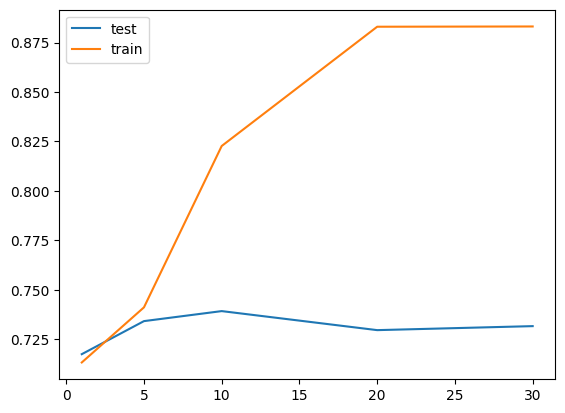

In [16]:
plt.plot(depths, test_accs, label='test')
plt.plot(depths, train_accs, label='train')
#plt.xscale('log')
plt.legend()
plt.show()

# Retrain Models under Dataset Shift - Synthetic Noise

In [28]:
# Standard deviations for synthetic noise
noise_seeds = range(10)
thresholds = np.logspace(-3, -0.3, 10)
thresholds

array([0.001     , 0.00199526, 0.00398107, 0.00794328, 0.01584893,
       0.03162278, 0.06309573, 0.12589254, 0.25118864, 0.50118723])

In [19]:
for i, depth in enumerate(tqdm(depths)):
    models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            perturb_params = datasets.PerturbParams(args.strategy, threshold,
                                                    args.target_indices, args.target_vals,
                                                    args.indices_to_change, args.new_vals)
            scaler, scaler_labels = None, None
            train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                             scaler_labels, noise_seed, perturb_params, noisy_test=False)
            model = RandomForestClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf, random_state=0)
            model = model.fit(train.data, train.labels.to_numpy()[:, 0])
            models.append(model)
    dump(models, output_dir+f'/models_depth{depth}.joblib')

100%|██████████| 5/5 [14:59<00:00, 179.93s/it]


# Compute Explanations

In [19]:
# Compute LIME explanations for one base model
def explain_lime(model, X_test):
    explainer = lime.lime_tabular.LimeTabularExplainer(X, class_names=['0', '1'],
                                                       discretize_continuous=False)
    lime_exps = np.zeros((X_test.shape[0], X_test.shape[1]))
    for idx in range(X_test.shape[0]):
        exp = explainer.explain_instance(X_test[idx], model.predict_proba,
                                        num_features=num_feat, num_samples=1000)
        feature_idxs = [int(i[0]) for i in exp.as_list()]
        lime_values = [i[1] for i in exp.as_list()]
        lime_exps[idx, feature_idxs] = np.array(lime_values)
    return np.array(lime_exps)

### SHAP Explanations

In [21]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute shap
    explainer = shap.Explainer(base)
    shap_test = explainer(X_test).values#[:, :, 1]

    # Save gradients/explanations
    dump(shap_test, output_dir+f'/base_shap_depth{depth}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}.joblib')
    
    shap_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute shap
            explainer = shap.Explainer(model)
            shap_test = explainer(X_test, check_additivity=False).values#"[:, :, 1]
            shap_test_models.append(shap_test)
    dump(shap_test_models, output_dir+f'/models_shap_depth{depth}.joblib')

100%|██████████| 5/5 [1:51:40<00:00, 1340.06s/it]


### LIME Explanations

In [29]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute lime
    lime_test = explain_lime(base, X_test[:100])

    # Save explanations
    dump(lime_test, output_dir+f'/base_lime_depth{depth}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}.joblib')
    
    lime_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute lime
            lime_test = explain_lime(model, X_test[:100])
            lime_test_models.append(lime_test)
    dump(lime_test_models, output_dir+f'/models_lime_depth{depth}.joblib')

100%|██████████| 5/5 [14:11<00:00, 170.34s/it]


# Compute Top-K Explanation Stability

In [30]:
from metrics import get_top_k, top_k_sa, top_k_cdc, top_k_ssa

In [31]:
exps = ['shap', 'lime'] #['salience', 'smoothgrad', 'lime_grads', 'kernel_shap']
mets = [top_k_sa, top_k_cdc, top_k_ssa] #
met_names = ['sa', 'cdc', 'ssa']
ks = [5]  # values of k in top-k

In [32]:
from joblib import load
output_dir = 'models/heloc_retraining_forest'
exp_test_models = load(output_dir+f'/models_lime_depth30.joblib')

In [43]:
g1 = load(output_dir+f'/base_shap_depth{depth}.joblib')
exp_test_models = load(output_dir+f'/models_shap_depth{depth}.joblib')
exp_test_models[0].shape

(1975, 23, 2)

In [33]:
for exp in exps:
    print(f'Computing {exp.title()} Metrics...')
    for m, met in enumerate(tqdm(mets)):
        for k in ks:
            exp_met_ks = np.zeros((len(depths), len(thresholds), len(noise_seeds)))
            for i, depth in enumerate(depths):
                # g1 represents base model gradients
                g1 = load(output_dir+f'/base_{exp}_depth{depth}.joblib')
                g1 = g1[:, :, 1] if exp=='shap' else g1
                s1 = np.sign(g1)
                tk1 = get_top_k(k, g1)

                # Load explanations from models
                exp_test_models = load(output_dir+f'/models_{exp}_depth{depth}.joblib')

                for j, threshold in enumerate(thresholds):
                    for idx, noise_seed in enumerate(noise_seeds):
                        # g2 represents shifted model explanations
                        g2 = exp_test_models[j*len(noise_seeds) + idx]
                        g2 = g2[:, :, 1] if exp=='shap' else g2
                        s2 = np.sign(g2)
                        tk2 = get_top_k(k, g2)
                        exp_met_ks[i,j,idx] = met(k, tk1, tk2, s1, s2)

            # save exp-met-k combo
            dump(exp_met_ks, output_dir+f'/{exp}_top_{k}_{met_names[m]}.npy')

Computing Shap Metrics...


100%|██████████| 3/3 [00:17<00:00,  5.89s/it]


Computing Lime Metrics...


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


# Plot Explanation Stability

In [34]:
exps = ['shap', 'lime']
met_names = ['sa', 'cdc', 'ssa']
met_names_full = ['Sign-Agreement (SA)',
                  'Consistent-Direction-of-Contribution (CDC)',
                  'Signed-Set-Agreement (SSA)']
k=5

### All Similarity Metrics

In [35]:
topk = load(output_dir+f'/lime_top_5_ssa.npy')
topk2 = load(output_dir+f'/lime_top_5_cdc.npy')

In [36]:
g1 = load(output_dir+f'/base_lime_depth30.joblib')

In [37]:
g1[0]

array([ 0.06745733,  0.01462307,  0.00454681,  0.03944423,  0.02267827,
       -0.00439069, -0.00389734,  0.04316117,  0.02007934,  0.01783744,
        0.00926636,  0.01123988, -0.00071345, -0.00598749,  0.02904451,
       -0.00817614, -0.0050075 , -0.03490432, -0.00970709, -0.00764956,
        0.00393709, -0.01290433, -0.0089573 ])

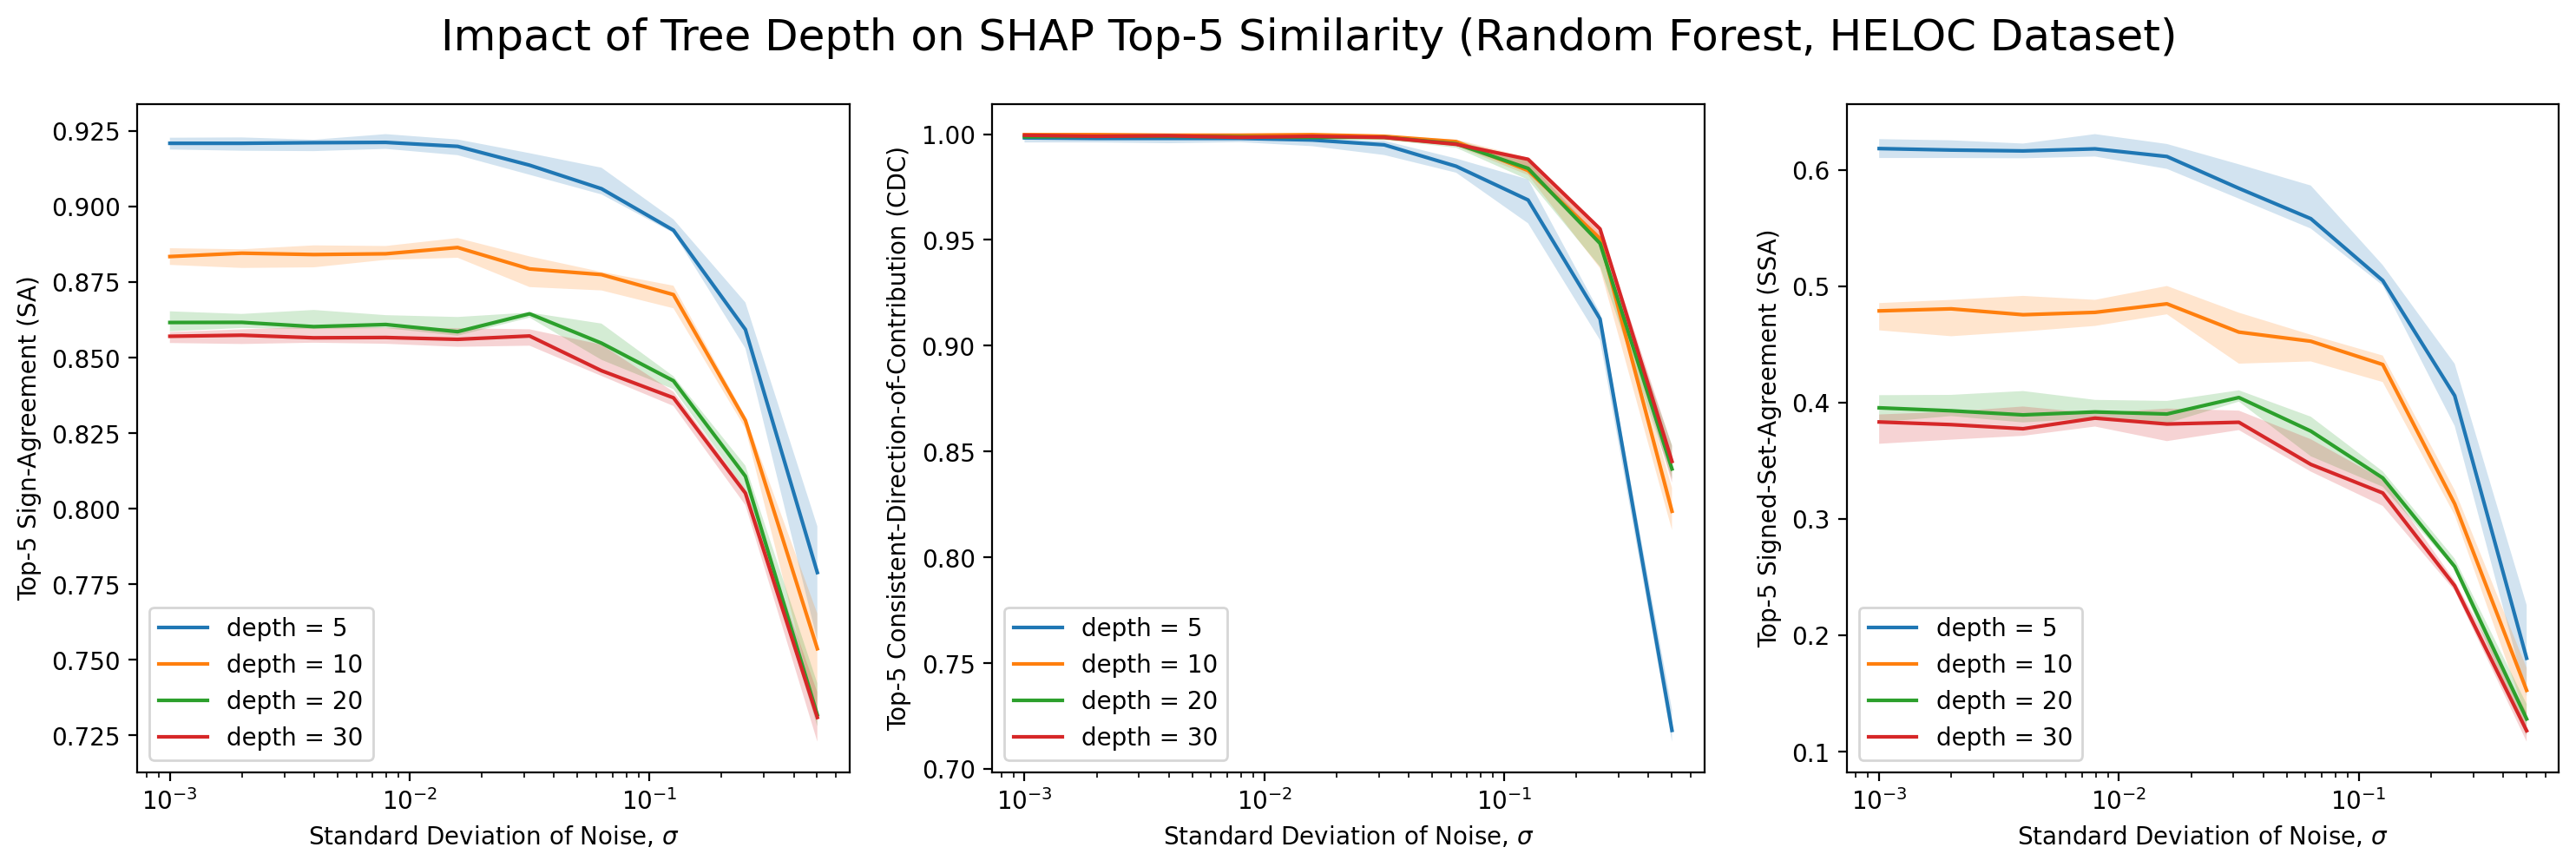

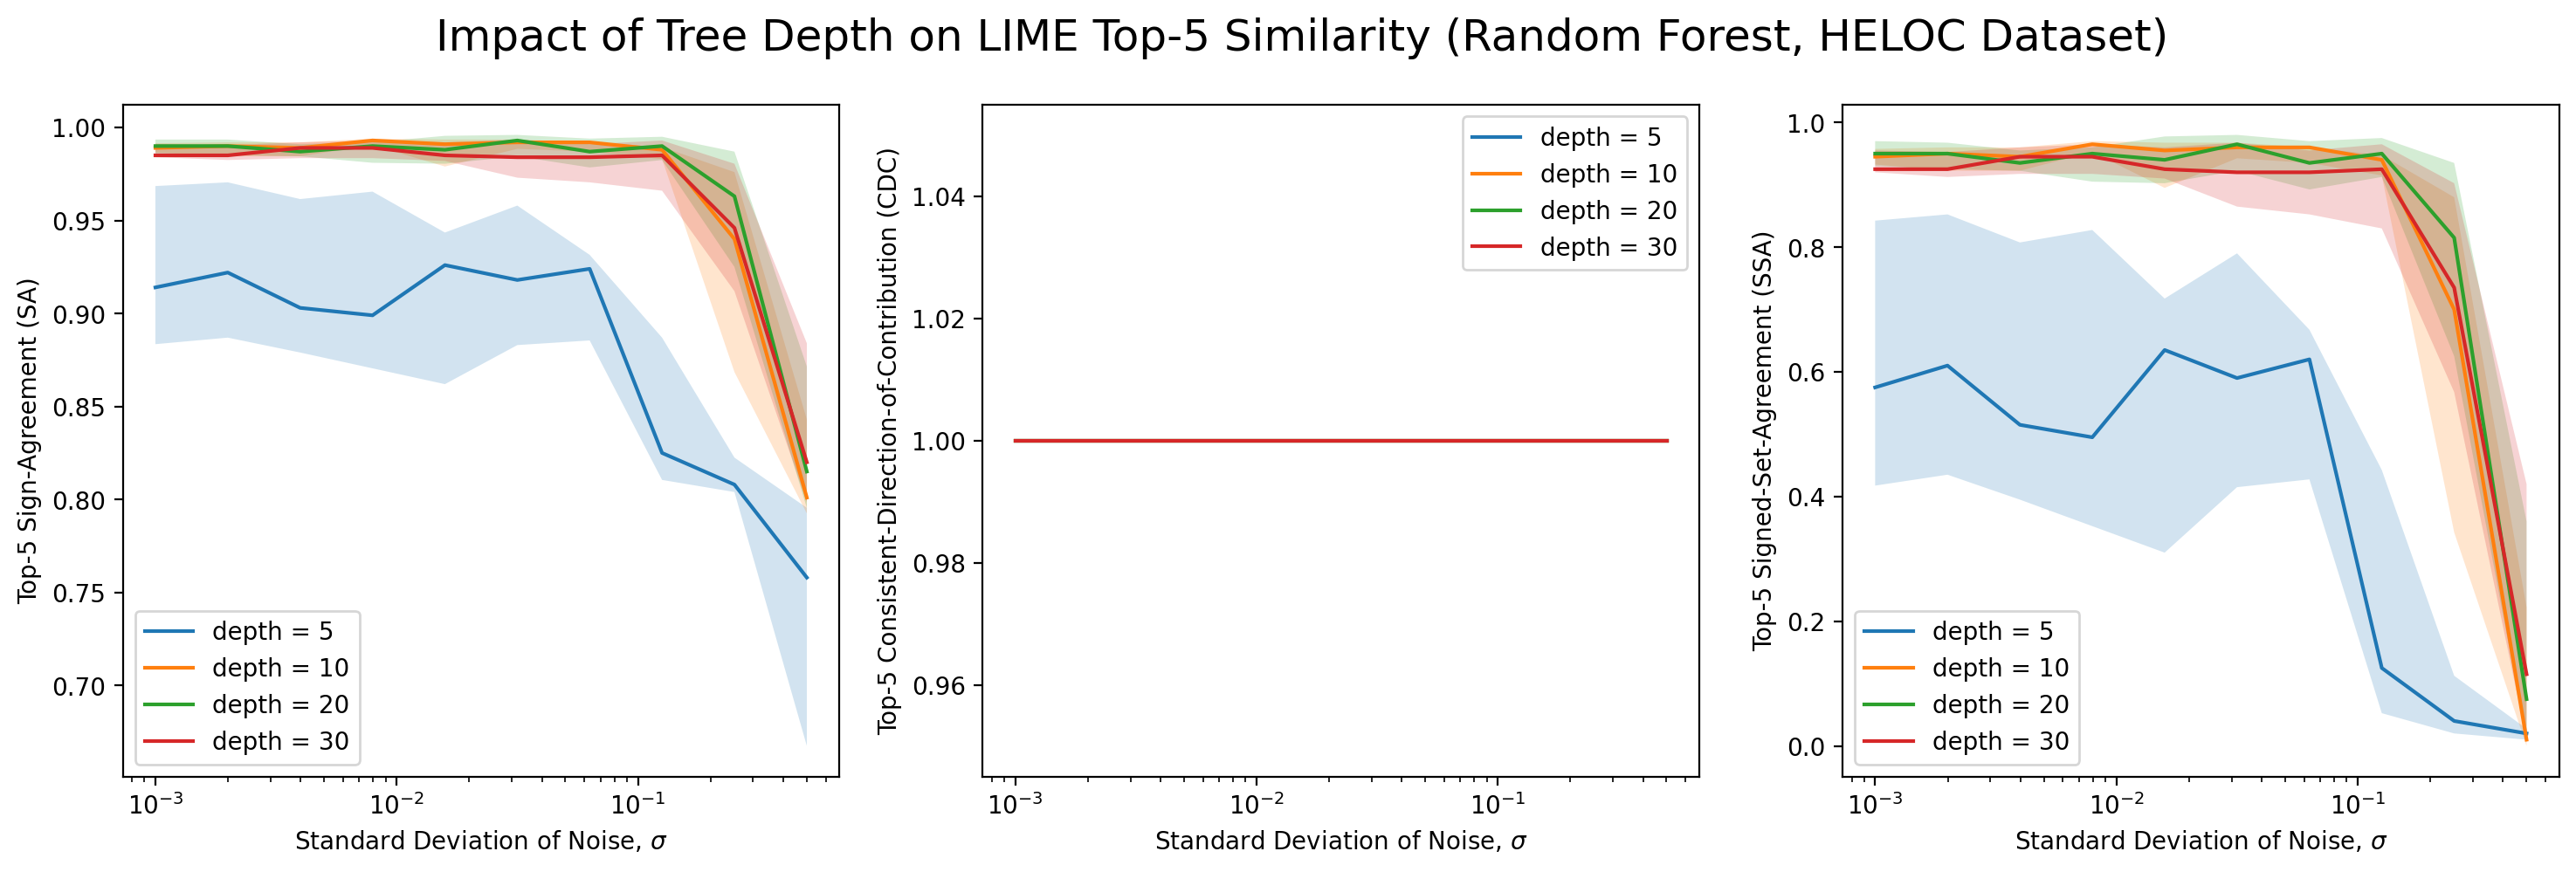

In [38]:
for exp in exps:
    fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=200)
    for i, met in enumerate(met_names):
        topk = load(output_dir+f'/{exp}_top_{k}_{met}.npy')
        ax[i].set_ylabel(f'Top-{k} {met_names_full[i]}')
        ax[i].set_xlabel('Standard Deviation of Noise, $\sigma$')
        for j, depth in enumerate(depths):
            if j > 0:
                q = np.quantile(topk[j], [0.25, 0.5, 0.75], axis=1)
                ax[i].plot(thresholds, q[1], label=f'depth = {depth}')
                ax[i].fill_between(thresholds, q[0], q[2], alpha=0.2)
        ax[i].set_xscale('log')
        ax[i].legend()
    plt.suptitle(f'Impact of Tree Depth on {exp.upper()} Top-5 Similarity (Random Forest, HELOC Dataset)', fontsize=18)
    plt.show()

### Single Similarity Metric

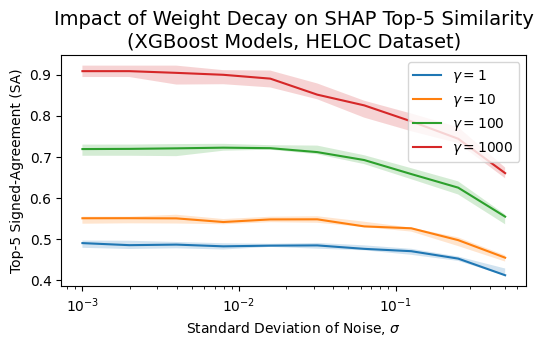

In [133]:
topk = load(output_dir+f'/shap_top_{k}_sa_lambda.npy')
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Weight Decay on SHAP Top-5 Similarity\n(XGBoost Models, HELOC Dataset)', fontsize=14)
plt.ylabel('Top-5 Signed-Agreement (SA)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, depth in enumerate(depths):
    q = np.quantile(topk[i], [0.25, 0.5, 0.75], axis=1)
    plt.plot(thresholds, q[1], label=f'depth = {depth}')
    plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend()
plt.show()

### Test Accuracy

In [30]:
# Load models
model_accs = []
for i, depth in enumerate(tqdm(depths)):
    models = load(output_dir+f'/models_depth{depth}.joblib')
    model_acc = np.zeros((len(thresholds), len(noise_seeds)))
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            model_acc[j,idx] = (model.predict(X_test)==y_test).mean()
    model_accs.append(model_acc)

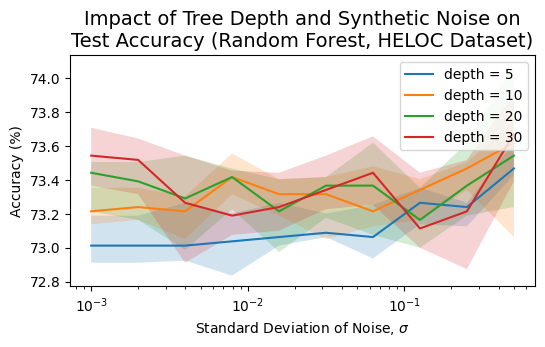

In [32]:
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Tree Depth and Synthetic Noise on\nTest Accuracy (Random Forest, HELOC Dataset)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, depth in enumerate(depths):
    if i>0:
        q = np.quantile(model_accs[i], [0.25, 0.5, 0.75], axis=1)*100
        plt.plot(thresholds, q[1], label=f'depth = {depth}')
        plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()